# Anomaly Detection

This notebook shows some basic usage of CapyMOA for anomaly detection tasks.

Algorithms: `HalfSpaceTrees`, `Autoencoder` and `Online Isolation Forest`

Important notes: Prior to version 0.8.2, a lower anomaly score indicated a higher likelihood of an anomaly. This has been updated so that a higher anomaly score now indicates a higher likelihood of an anomaly, aligning with the standard anomaly detection literature.

---

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last update on 28/11/2025**

## 1. Creating simple anomalous data with `sklearn`

* Generating a few examples and some simple anomalous data using `sklearn`.

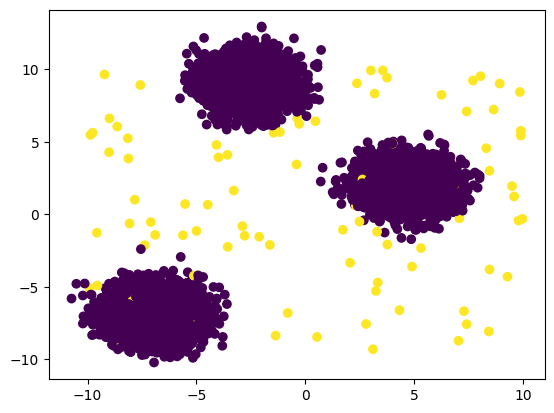

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream

# generate normal data points
n_samples = 10000
n_features = 2
n_clusters = 3
X, y = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
)

# generate anomalous data points
n_anomalies = 100  # the anomaly rate is 1%
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1] * n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

# shuffle the data
idx = np.random.permutation(n_samples + n_anomalies)
X = X[idx]
y = y[idx]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

## 2. Unsupervised anomaly detection for data streams

* Recent research has been focused on unsupervised anomaly detection for data streams, as it is often difficult to obtain labeled data for training.
* Instead of using evaluation functions, we first use a basic **test-then-train loop** from scratch to evaluate the model's performance.
* Please note that higher scores indicate higher anomaly likelihood.

In [2]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import AnomalyDetectionEvaluator

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
learner = HalfSpaceTrees(stream_ad.get_schema())
evaluator = AnomalyDetectionEvaluator(stream_ad.get_schema())
while stream_ad.has_more_instances():
    instance = stream_ad.next_instance()
    score = learner.score_instance(instance)
    evaluator.update(instance.y_index, score)
    learner.train(instance)

auc = evaluator.auc()
print(f"AUC: {auc:.2f}")

AUC: 0.94


## 3. High-level evaluation functions

* CapyMOA provides `prequential_evaluation_anomaly` as a high level function to assess anomaly detectors.

### 3.1 `prequential_evaluation_anomaly`
In this example, we use the `prequential_evaluation_anomaly` function with `plot_windowed_results` to plot AUC for HalfSpaceTrees on the synthetic data stream.

AUC: 0.941246


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.849184,0.171061,0.072,0.002236,0.000000,0.020408,0.23035,1.0,-45.400000
1,2000.0,0.944165,0.174102,0.006,0.000000,0.849184,0.006036,0.00000,1.0,-75.461538
2,3000.0,0.971457,0.179944,0.005,0.000000,0.944165,0.005025,0.00000,1.0,-95.290323
3,4000.0,0.911775,0.186154,0.012,0.000000,0.971457,0.012146,0.00000,1.0,-90.906977
4,5000.0,0.965418,0.226645,0.012,0.000000,0.911775,0.012146,0.00000,1.0,-88.818182
5,6000.0,0.892786,0.126597,0.002,0.000000,0.965418,0.002004,0.00000,1.0,-104.052632
6,7000.0,0.990462,0.254736,0.004,0.000000,0.892786,0.004016,0.00000,1.0,-113.295082
7,8000.0,0.951739,0.210340,0.008,0.000000,0.990462,0.008065,0.00000,1.0,-114.014493
8,9000.0,0.957681,0.197744,0.013,0.000000,0.951739,0.013171,0.00000,1.0,-107.329268
9,10000.0,0.981997,0.183113,0.015,0.000000,0.957681,0.015228,0.00000,1.0,-100.546392


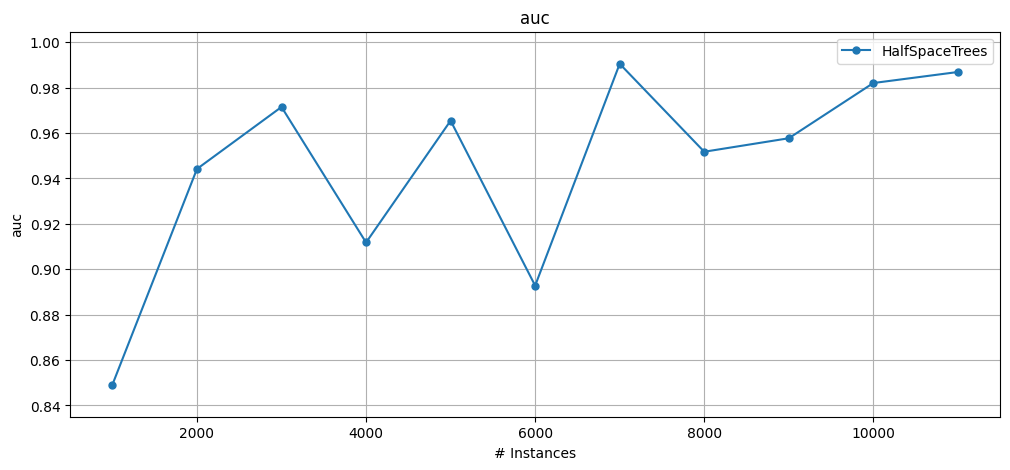

In [3]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
hst = HalfSpaceTrees(schema=stream_ad.get_schema())

results_hst = prequential_evaluation_anomaly(
    stream=stream_ad, learner=hst, window_size=1000
)

print(f"AUC: {results_hst.auc()}")
display(results_hst.windowed.metrics_per_window())
plot_windowed_results(results_hst, metric="auc", save_only=False)

### 3.2 Autoencoder

AUC: 0.48654


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.535663,1.642701e-03,0.980,0.000000,0.000000,0.020408,0.0,0.0,0.000000
1,2000.0,0.519282,2.853784e-06,0.994,0.000000,0.535663,0.006036,0.0,0.0,0.538462
2,3000.0,0.604623,6.522853e-07,0.994,-0.001669,0.519282,0.005025,0.0,0.0,0.419355
3,4000.0,0.405533,1.512772e-09,0.988,0.000000,0.604623,0.012146,0.0,0.0,-0.116279
4,5000.0,0.575574,1.320404e-03,0.986,-0.003440,0.405533,0.012146,0.0,0.0,-0.272727
5,6000.0,0.352705,6.562480e-11,0.998,0.000000,0.575574,0.002004,0.0,0.0,0.789474
6,7000.0,0.556225,2.833118e-08,0.995,-0.001603,0.352705,0.004016,0.0,0.0,0.426230
7,8000.0,0.542591,5.121751e-02,0.992,0.000000,0.556225,0.008065,0.0,0.0,0.072464
8,9000.0,0.370041,1.087457e-02,0.986,-0.001861,0.542591,0.013171,0.0,0.0,-0.536585
9,10000.0,0.432081,1.567464e-04,0.985,0.000000,0.370041,0.015228,0.0,0.0,-0.546392


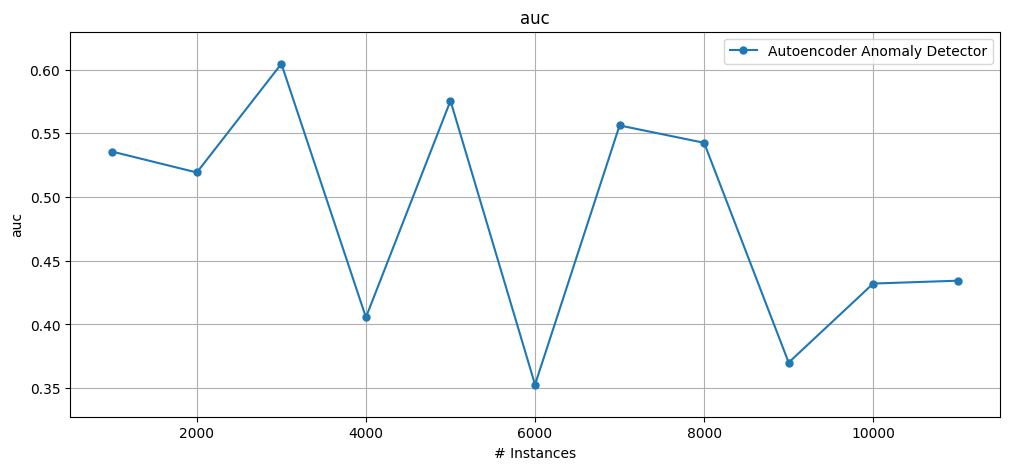

In [4]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import Autoencoder
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
ae = Autoencoder(schema=stream_ad.get_schema(), hidden_layer=1)

results_ae = prequential_evaluation_anomaly(
    stream=stream_ad, learner=ae, window_size=1000
)

print(f"AUC: {results_ae.auc()}")
display(results_ae.windowed.metrics_per_window())
plot_windowed_results(results_ae, metric="auc", save_only=False)

### 3.3 Online Isolation Forest

AUC: 0.817661


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.693571,0.032058,0.947,-0.025542,0.000000,0.020408,0.0,0.0,-1.650000
1,2000.0,0.805500,0.027358,0.994,0.000000,0.693571,0.006036,0.0,0.0,0.538462
2,3000.0,0.713769,0.049567,0.995,0.000000,0.805500,0.005025,0.0,0.0,0.516129
3,4000.0,0.763917,0.029381,0.988,0.000000,0.713769,0.012146,0.0,0.0,-0.116279
4,5000.0,0.910762,0.065502,0.988,0.000000,0.763917,0.012146,0.0,0.0,-0.090909
5,6000.0,0.761022,0.024456,0.998,0.000000,0.910762,0.002004,0.0,0.0,0.789474
6,7000.0,0.733434,0.035292,0.996,0.000000,0.761022,0.004016,0.0,0.0,0.540984
7,8000.0,0.852445,0.054641,0.992,0.000000,0.733434,0.008065,0.0,0.0,0.072464
8,9000.0,0.830800,0.050422,0.987,0.000000,0.852445,0.013171,0.0,0.0,-0.426829
9,10000.0,0.940237,0.073304,0.985,0.000000,0.830800,0.015228,0.0,0.0,-0.546392


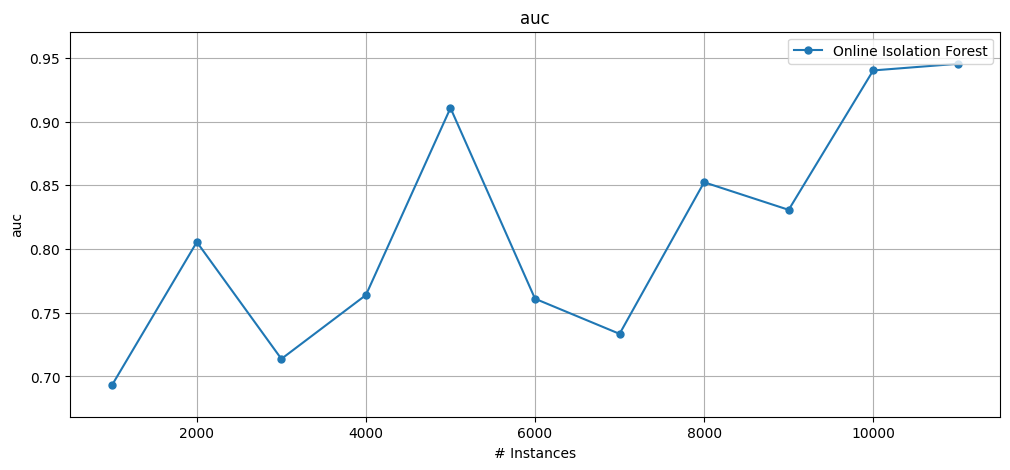

In [5]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
oif = OnlineIsolationForest(schema=stream_ad.get_schema(), num_trees=10)

results_oif = prequential_evaluation_anomaly(
    stream=stream_ad, learner=oif, window_size=1000
)

print(f"AUC: {results_oif.auc()}")
display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## 4. Comparing algorithms

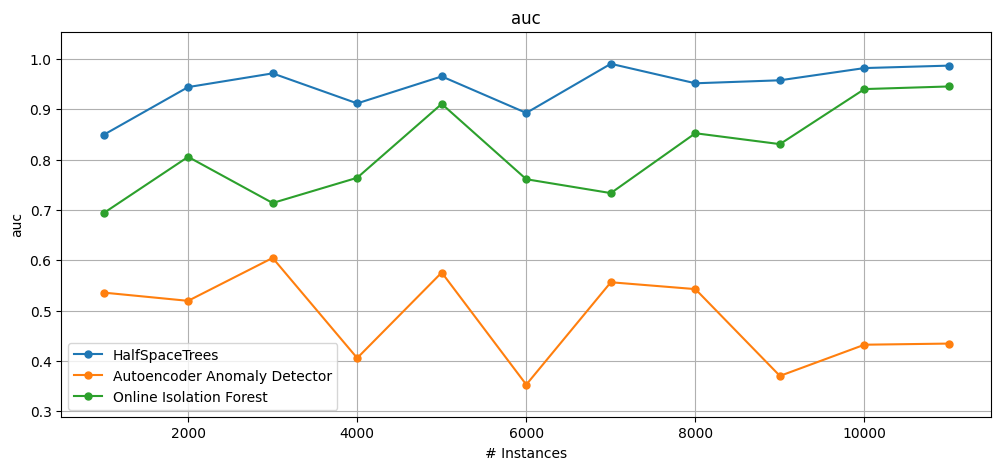

In [6]:
plot_windowed_results(
    results_hst, results_ae, results_oif, metric="auc", save_only=False
)